# Correlation regarding the Children to Teachers Ratio


In [31]:
from school_analysis.preprocessing.helpers.students_teachers import combine_school_type
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
import school_analysis as sa
from school_analysis.plotting.general import GeneralPlots
from school_analysis.preprocessing import SCHOOL_TYPE_MAPPING
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

loader = Loader()

# Budgets
budget = loader.load("budgets-corrected")

# Grades
grades = loader.load("abi-grades")
grades_temp = grades.T.reset_index().rename(
    columns={"level_0": "Federal State", "level_1": "Year"})
grades = pd.melt(grades_temp, id_vars=[
                 "Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")
grades["Federal State"] = grades["Federal State"].map(sa.STATE_MAPPING)
grades["Year"] = grades["Year"].astype(int)
grades["Grade"] = grades["Grade"].astype(float)

# Repeaters
repeaters = loader.load("number_of_repeaters")
repeaters = repeaters.rename(columns={"state": "Federal State", "school": "School Type",
                             "year": "Year", "total": "Repeaters", "grade": "Grade"}).drop(columns=["male", "female"])
repeaters["Repeaters"] = repeaters["Repeaters"].replace(
    "-", np.nan).dropna().astype(int)

# Teachers to Students
teachers_students_state = loader.load("students-per-teacher-by-state")
teachers_students_state = teachers_students_state[
    (teachers_students_state["Gender_students"] == "all")
    & (teachers_students_state["Gender_teachers"] == "all")
]
teachers_students_type = loader.load("students-per-teacher-by-type")
teachers_students_type = teachers_students_type[
    (teachers_students_type["Gender_students"] == "all")
    & (teachers_students_type["Gender_teachers"] == "all")
]

# Pisa
pisa = loader.load("pisa-germany")

# Without Secondary Degrees
children_wo_degree = loader.load(
    "children_wo_degree").rename(columns={"year": "Year"})

CONTRACT_TYPE = [
    "Vollzeitbeschäftigte Lehrkräfte",
    "Teilzeitbeschäftigte Lehrkräfte",
    # "Stundenweise beschäftigte Lehrkräfte"
]

MAX_TEACHERS_PER_STUDENT = np.inf
teachers_students_state_outlier = teachers_students_state[
    (teachers_students_state["Contract Type"].isin(CONTRACT_TYPE))
    & (teachers_students_state["Students per Teacher"] > MAX_TEACHERS_PER_STUDENT)]
teachers_students_state_outlier
# Maybe remove these schools from the dataset

,Federal State,Gender_students,Type,Students,Year,Contract Type,Gender_teachers,Number of Teachers,Students per Teacher


## Teachers to Students Ratio vs. Grades


In [32]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
grades_c = grades.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[
    (ts_state_c["Gender_students"] == "all")
    & (ts_state_c["Gender_teachers"] == "all")
    & (ts_state_c["Contract Type"].isin(CONTRACT_TYPE))
]
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"]
ts_state_c = ts_state_c.groupby(["Federal State", "Year"])[
    "Students per Teacher"].mean().reset_index()
ts_state_c = ts_state_c[["Federal State", "Year",
                         "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(
    ["Year"])["Students per Teacher"].mean().reset_index()

grades_c["Grade"] = grades_c["Grade"]
avg_grade_state = grades_c.groupby(["Federal State", "Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum(), include_groups=False).reset_index().rename(columns={0: "Average Grade"})
avg_grade = grades_c.groupby(["Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum(), include_groups=False).reset_index().rename(columns={0: "Average Grade"})

In [33]:
grade_ts_state = pd.merge(ts_state_c, avg_grade_state,
                          on=["Federal State", "Year"])
grade_ts_state_avg = pd.merge(ts_state_avg, avg_grade, on=["Year"])

print("Corr [TS, Grade] by State: ", np.corrcoef(
    grade_ts_state["Students per Teacher"], grade_ts_state["Average Grade"])[0][1])
print("Corr [TS, Grade] by Avg over all States: ", np.corrcoef(
    grade_ts_state_avg["Students per Teacher"], grade_ts_state_avg["Average Grade"])[0][1])

Corr [TS, Grade] by State:  -0.08040573879345579
Corr [TS, Grade] by Avg over all States:  0.01166792923556527


In [34]:
grade_ts_state_avg

,Year,Students per Teacher,Average Grade
0,2007,28.780855,2.530665
1,2008,27.401484,2.523515
2,2009,26.819529,2.517675
3,2010,26.300047,2.500708
4,2011,26.709598,2.498626
5,2012,27.116056,2.472224
6,2013,27.483241,2.459223
7,2014,27.835946,2.456677
8,2015,27.708775,2.454814
9,2016,27.737487,2.435339


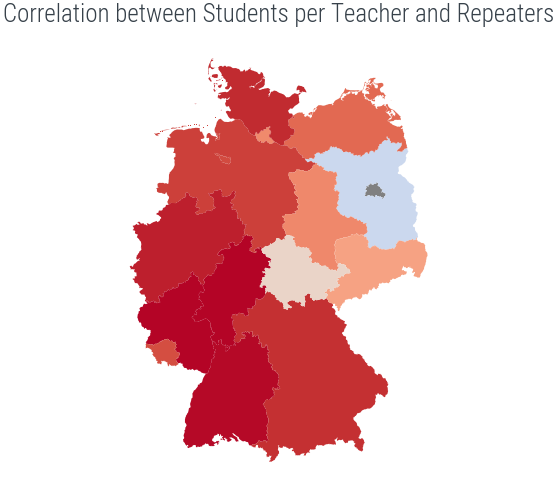

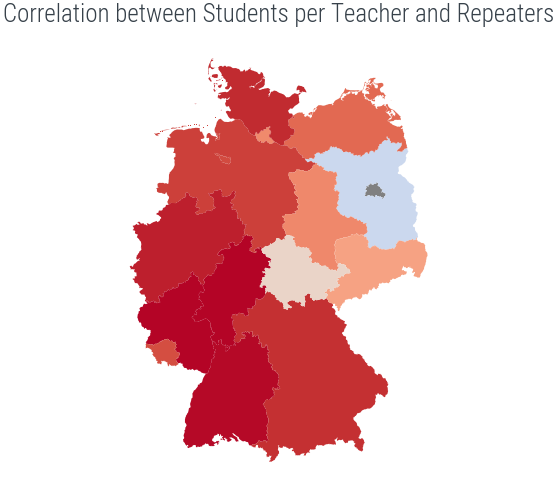

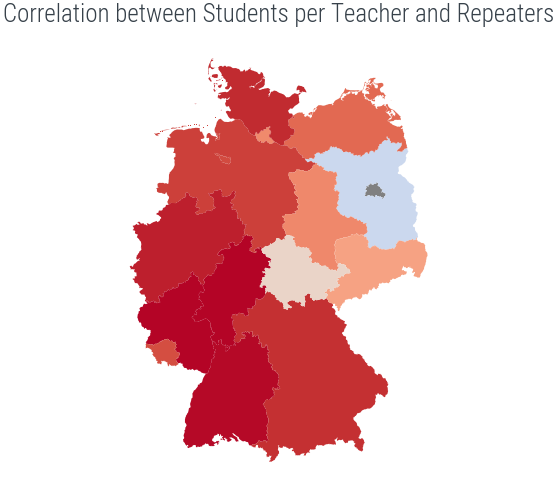

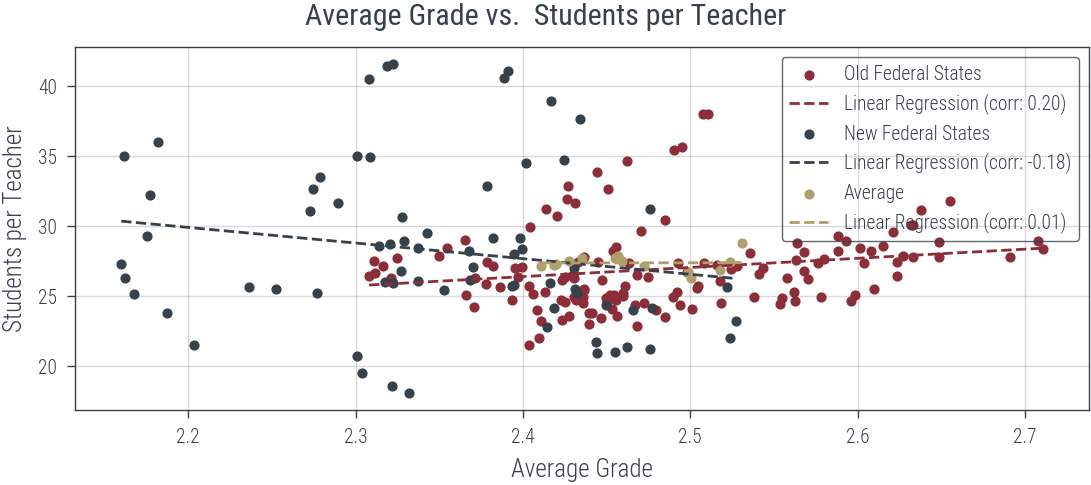

In [35]:
GeneralPlots.federal_state_corr_plot(
    grade_ts_state,
    "Students per Teacher",
    "Average Grade",
    melted_df=grade_ts_state_avg,
)

Generate a table of the correlations between the teachers to students ratio and the grades of the students for each federal state.


In [36]:
from tabulate import tabulate

result = []
for state in grade_ts_state["Federal State"].unique():
    state_data_grade = grade_ts_state[grade_ts_state["Federal State"] == state]
    corr = {}

    # Get corr
    corr["state"] = state
    corr["Avg. Grade - Students per Teacher"] = np.corrcoef(
        state_data_grade["Students per Teacher"], state_data_grade["Average Grade"])[0][1]
    corr["Type"] = "New" if state in sa.NEW_OLD_STATES_MAPPING["New Federal States"] else "Old"
    result.append(corr)

# Sort results
sorted_result = sorted(result, key=lambda x: x['Type'])

print(tabulate(sorted_result, headers="keys"))

state                     Avg. Grade - Students per Teacher  Type
----------------------  -----------------------------------  ------
Brandenburg                                       -0.856209  New
Mecklenburg-Vorpommern                            -0.16359   New
Sachsen                                           -0.713226  New
Sachsen-Anhalt                                    -0.800772  New
Thüringen                                         -0.682996  New
Baden-Württemberg                                 -0.60174   Old
Bayern                                             0.962903  Old
Bremen                                             0.739622  Old
Hamburg                                            0.952964  Old
Hessen                                             0.974667  Old
Niedersachsen                                      0.589166  Old
Nordrhein-Westfalen                                0.956346  Old
Rheinland-Pfalz                                    0.82787   Old
Saarland             

## Correlation between the teachers to students ratio and the budget per student


In [37]:
# Get data
budget_c = budget.copy()

# Filter the data to only required cols
budget_c = budget_c.drop(columns=["Year Relative", "Index"])
budget_c_avg = budget_c.groupby(

    ["Year"])["Reference Budget"].mean().reset_index()

In [38]:
ts_budget_state = pd.merge(ts_state_c, budget_c, on=[
                           "Federal State", "Year"]).dropna().drop_duplicates()
ts_budget_state_avg = pd.merge(ts_state_avg, budget_c_avg, on=[
                               "Year"]).dropna().drop_duplicates()

print("Corr [TS, Budget] by State: ", np.corrcoef(
    ts_budget_state["Students per Teacher"], ts_budget_state["Reference Budget"])[0][1])
print("Corr [TS, Budget] by Avg over all States: ", np.corrcoef(
    ts_budget_state_avg["Students per Teacher"], ts_budget_state_avg["Reference Budget"])[0][1])

Corr [TS, Budget] by State:  -0.11930753076997831
Corr [TS, Budget] by Avg over all States:  0.11960311646228262


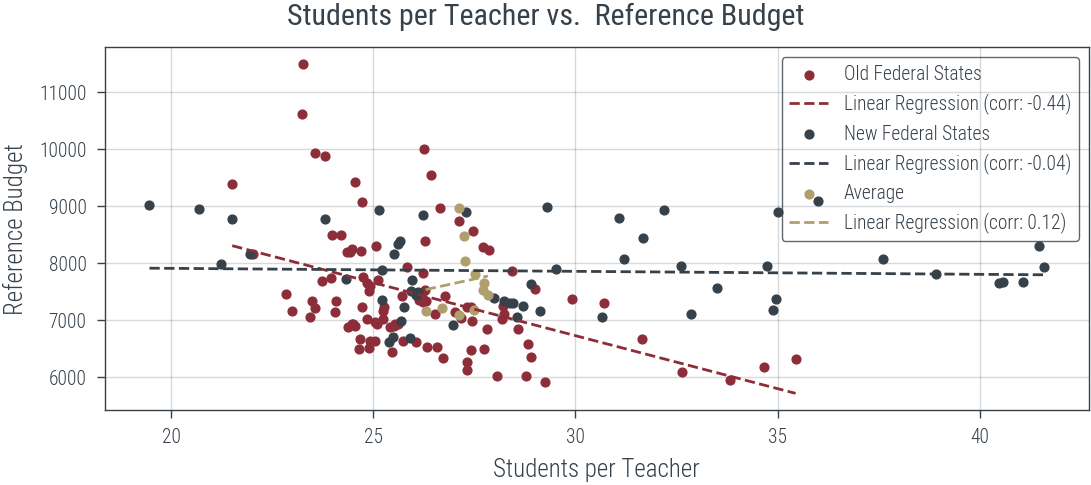

In [39]:
GeneralPlots.federal_state_corr_plot(
    ts_budget_state,
    "Reference Budget",
    "Students per Teacher",
    melted_df=ts_budget_state_avg,
)

## Correlation between the teachers to students ratio and the repeater rate


In [40]:
# Get data
repeaters_c = repeaters.copy()

# Filter the data to only required cols
repeaters_state = repeaters_c.groupby(["Federal State", "Year"])[
    "Repeaters"].mean().reset_index()
repeaters_avg = repeaters_c.groupby(["Year"])["Repeaters"].mean().reset_index()

In [41]:
ts_repeaters_state = pd.merge(ts_state_c, repeaters_state, on=[
                              "Federal State", "Year"]).dropna().drop_duplicates()
ts_repeaters_state_avg = pd.merge(ts_state_avg, repeaters_avg, on=[
                                  "Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by State: ", np.corrcoef(
    ts_repeaters_state["Students per Teacher"], ts_repeaters_state["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all States: ", np.corrcoef(
    ts_repeaters_state_avg["Students per Teacher"], ts_repeaters_state_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by State:  0.1385939762185929
Corr [TS, Repeaters] by Avg over all States:  0.8307627945633175


In [42]:
outlier = ts_repeaters_state[ts_repeaters_state["Students per Teacher"]
                             > MAX_TEACHERS_PER_STUDENT]
ts_repeaters_state.drop(outlier.index, inplace=True)
outlier

,Federal State,Year,Students per Teacher,Repeaters


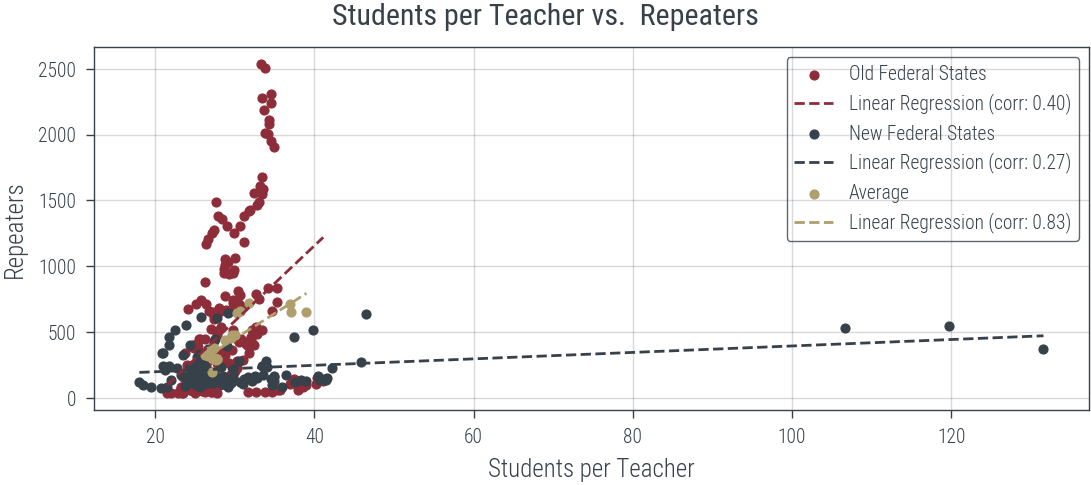

In [43]:
GeneralPlots.federal_state_corr_plot(
    ts_repeaters_state,
    "Repeaters",
    "Students per Teacher",
    melted_df=ts_repeaters_state_avg,
)

## Correlation between the teachers to students ratio and the repeater by school type


In [44]:
# Get data
repeaters_c = repeaters.copy()
repeaters_c["School Type"] = repeaters_c["School Type"].map(
    SCHOOL_TYPE_MAPPING)
repeaters_c = combine_school_type(
    repeaters_c, "School Type", "Repeaters", new_type="Gymnasien")
repeaters_c = repeaters_c.dropna().drop_duplicates()

# Filter the data to only required cols
ts_type_c = ts_type_c[
    (ts_type_c["Gender_students"] == "all")
    & (ts_type_c["Gender_teachers"] == "all")
    & (ts_type_c["Contract Type"].isin(CONTRACT_TYPE))
]
ts_type_c = ts_type_c.groupby(["School Type", "Year"])[
    "Students per Teacher"].mean().reset_index()
ts_type_avg = ts_type_c.groupby(
    ["Year"])["Students per Teacher"].mean().reset_index()

repeaters_type = repeaters_c.groupby(["School Type", "Year"])[
    "Repeaters"].mean().reset_index()
repeaters_avg = repeaters_c.groupby(["Year"])["Repeaters"].mean().reset_index()

In [45]:
ts_repeaters_type = pd.merge(ts_type_c, repeaters_type, on=[
                             "School Type", "Year"]).dropna().drop_duplicates()
ts_repeaters_type_avg = pd.merge(ts_type_avg, repeaters_avg, on=[
                                 "Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by Type: ", np.corrcoef(
    ts_repeaters_type["Students per Teacher"], ts_repeaters_type["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all Types: ", np.corrcoef(
    ts_repeaters_type_avg["Students per Teacher"], ts_repeaters_type_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by Type:  0.5946465583529936
Corr [TS, Repeaters] by Avg over all Types:  0.41604816707865794


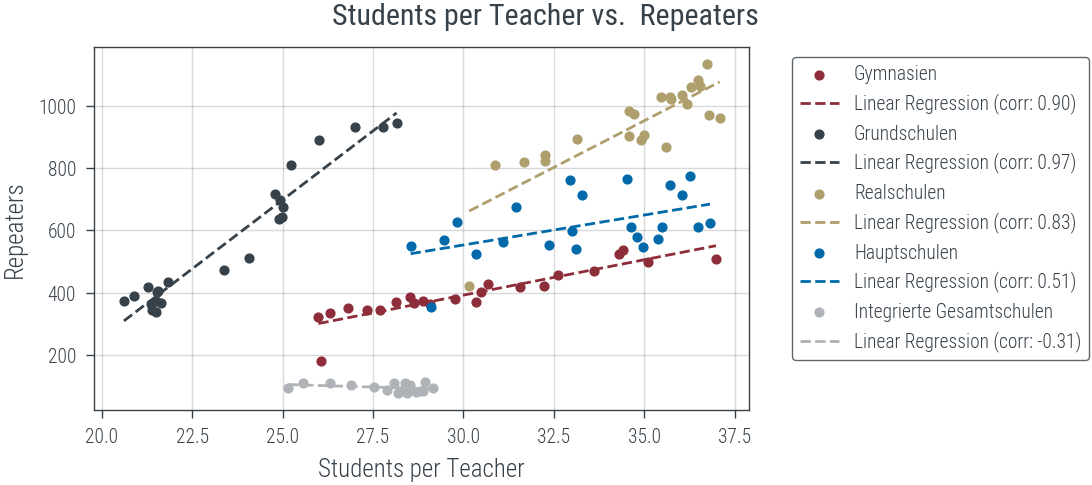

In [46]:
from school_analysis.preprocessing.helpers.students_teachers import get_most_common_school_types


GeneralPlots.school_type_corr_plot(
    ts_repeaters_type,
    "Repeaters",
    "Students per Teacher",
    school_types=get_most_common_school_types(
        teachers_students_type, 5, school_type_col="School Type", value_col="Students"),
    avg=False
)

In [47]:
ts_repeaters_type["School Type"].unique()

array(['Grundschulen', 'Gymnasien', 'Hauptschulen',
       'Integrierte Gesamtschulen', 'Realschulen',
       'Schularten mit mehreren Bildungsgängen'], dtype=object)

## Teachers to Students Ratio vs. Pisa


In [48]:
pisa

,Year,Jurisdiction,Subject,Value,Measure,Type
12,2003,International Average (OECD),math,499.463525,avg,all
13,2003,Germany,math,502.985533,avg,all
28,2003,International Average (OECD),math,0.552362,std,all
29,2003,Germany,math,3.317209,std,all
172,2003,International Average (OECD),read,494.085966,avg,all
...,...,...,...,...,...,...
259,2022,Germany,read,3.360647,std,repeated never
396,2022,International Average (OECD),science,492.793006,avg,repeated never
397,2022,Germany,science,514.216343,avg,repeated never
412,2022,International Average (OECD),science,0.439850,std,repeated never


In [49]:
pisa_c = pisa.copy()
ts_state_c = teachers_students_state.copy()

# Filter the data to only required cols
pisa_c = pisa_c[(pisa_c["Jurisdiction"] == "Germany") & (
    pisa_c["Measure"] == "avg") & (pisa_c["Type"] == "all")].drop(columns=["Jurisdiction", "Measure", "Type"]).drop_duplicates()
pisa_avg = pisa_c.groupby(["Year"])["Value"].mean().reset_index()

ts_state_c = ts_state_c.groupby(
    ["Year"])["Students per Teacher"].mean().reset_index()

In [50]:
# Merge
pisa_ts = pd.merge(pisa_c, ts_state_c, on=["Year"]).dropna().drop_duplicates()
pisa_ts_avg = pd.merge(pisa_avg, ts_state_c, on=[

                       "Year"]).dropna().drop_duplicates()

print("Corr [TS, PISA] by State: ", np.corrcoef(
    pisa_ts["Value"], pisa_ts["Students per Teacher"])[0][1])
print("Corr [TS, PISA] by Avg over all States: ", np.corrcoef(
    pisa_ts_avg["Value"], pisa_ts_avg["Students per Teacher"])[0][1])

Corr [TS, PISA] by State:  -0.33718231105858537
Corr [TS, PISA] by Avg over all States:  -0.5800996522445886


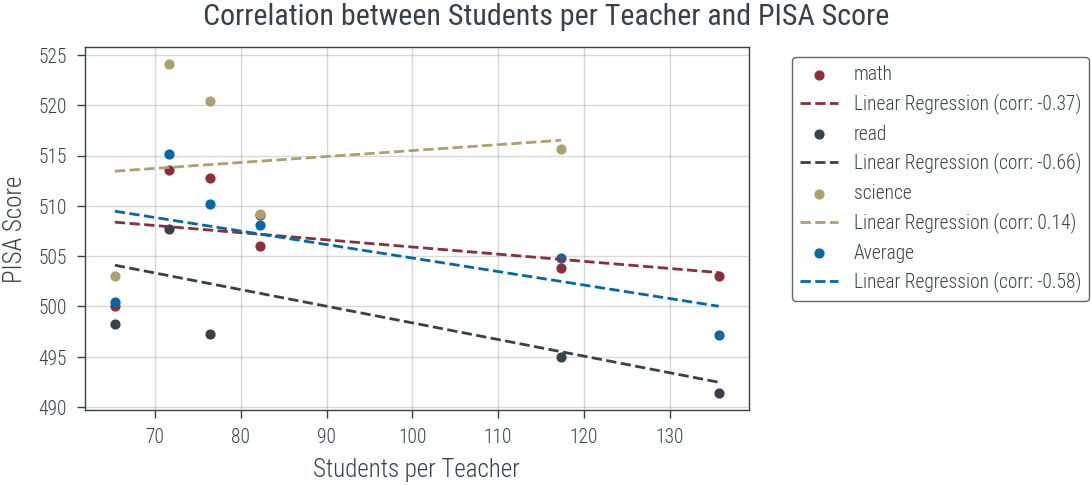

In [51]:
fig, ax = plt.subplots(1, 1)

for subject in pisa_ts["Subject"].unique():
    pisa_ts_subject = pisa_ts[pisa_ts["Subject"] == subject]
    ax.scatter(
        pisa_ts_subject["Students per Teacher"],
        pisa_ts_subject["Value"],
        s=10,
        label=subject
    )

    # Linear regression
    corr = np.corrcoef(
        pisa_ts_subject["Students per Teacher"], pisa_ts_subject["Value"])[0][1]
    X = np.vstack([np.ones(len(pisa_ts_subject["Students per Teacher"])),
                   pisa_ts_subject["Students per Teacher"]]).T
    y = pisa_ts_subject["Value"]
    w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
    minimum = pisa_ts_subject["Students per Teacher"].min()
    maximum = pisa_ts_subject["Students per Teacher"].max()
    xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
    ax.plot(
        xp,
        w[0] + w[1] * xp,
        "--",
        label="Linear Regression (corr: {:.2f})".format(corr)
    )

ax.scatter(
    pisa_ts_avg["Students per Teacher"],
    pisa_ts_avg["Value"],
    s=10,
    label="Average"
)

# Linear regression
corr = np.corrcoef(
    pisa_ts_avg["Students per Teacher"], pisa_ts_avg["Value"])[0][1]
X = np.vstack([np.ones(len(pisa_ts_avg["Students per Teacher"])),
               pisa_ts_avg["Students per Teacher"]]).T
y = pisa_ts_avg["Value"]
w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
minimum = pisa_ts_avg["Students per Teacher"].min()
maximum = pisa_ts_avg["Students per Teacher"].max()
xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
ax.plot(
    xp,
    w[0] + w[1] * xp,
    "--",
    label="Linear Regression (corr: {:.2f})".format(corr)
)

ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Students per Teacher")
ax.set_ylabel("PISA Score")
fig.suptitle("Correlation between Students per Teacher and PISA Score")
plt.show()

## Correlation table for each federal state and the teachers to students ratio


In [52]:
def correlation(data_frame: pd.DataFrame, col1: str, col2: str) -> float:
    return np.corrcoef(data_frame[col1], data_frame[col2])[0][1]

In [53]:
from tabulate import tabulate

result = []
for state in grade_ts_state["Federal State"].unique():
    state_data_grade = grade_ts_state[grade_ts_state["Federal State"] == state]
    state_data_budget = ts_budget_state[ts_budget_state["Federal State"] == state]
    state_data_repeaters = ts_repeaters_state[ts_repeaters_state["Federal State"] == state]
    corr = {}
    # Get corr
    corr["Avg. Grade"] = correlation(
        state_data_grade, "Students per Teacher", "Average Grade")
    corr["Budget"] = correlation(
        state_data_budget, "Students per Teacher", "Reference Budget")
    corr["Repeaters"] = correlation(
        state_data_repeaters, "Students per Teacher", "Repeaters")

    # Meta
    corr["state"] = state
    corr["Type"] = "New" if state in sa.NEW_OLD_STATES_MAPPING["New Federal States"] else "Old"
    result.append(corr)

result = pd.DataFrame(result).sort_values(
    by=["Type", "Avg. Grade"], ascending=False)
result

,Avg. Grade,Budget,Repeaters,state,Type
5,0.974667,-0.854133,0.948629,Hessen,Old
10,0.964555,-0.901367,0.775455,Saarland,Old
1,0.962903,-0.931942,0.867291,Bayern,Old
8,0.956346,-0.962334,0.904222,Nordrhein-Westfalen,Old
4,0.952964,-0.876176,0.547055,Hamburg,Old
9,0.827870,-0.675026,0.953174,Rheinland-Pfalz,Old
3,0.739622,-0.846596,0.785716,Bremen,Old
13,0.690506,-0.960465,0.881204,Schleswig-Holstein,Old
7,0.589166,-0.798882,0.823728,Niedersachsen,Old
0,-0.601740,-0.936641,0.945563,Baden-Württemberg,Old


Now we want to create a bar chart for each federal state that shows the correlation between the teachers to students ratio and the grades of the students.


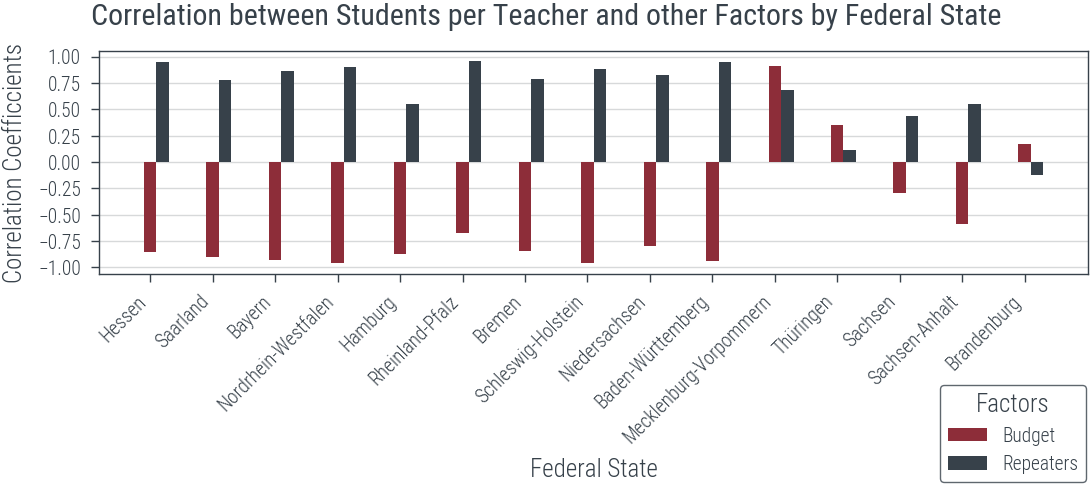

In [54]:
fig, ax = plt.subplots(1,  1)

# Define the number of bars and their positions
num_bars = 3
bar_width = 0.2
positions = np.arange(len(result["state"]))

# Create the bars
# ax.bar(positions - bar_width,
#        result["Avg. Grade"], width=bar_width, label="Avg. Grade")
ax.bar(positions, result["Budget"], width=bar_width, label="Budget")
ax.bar(positions + bar_width,
       result["Repeaters"], width=bar_width, label="Repeaters")

# Set the x-ticks to be the middle of the bars
ax.set_xticks(positions)
ax.set_ylabel("Correlation Coefficcients")
ax.set_xlabel("Federal State")
ax.set_xticklabels(result["state"], rotation=45, ha='right')
ax.legend(title="Factors", bbox_to_anchor=(
    0.85, -0.5), loc='upper left', borderaxespad=0.)
ax.grid(axis="y")
ax.set_yticks(np.arange(-1, 1.1, 0.25))

fig.suptitle(
    "Correlation between Students per Teacher and other Factors by Federal State")
plt.show()

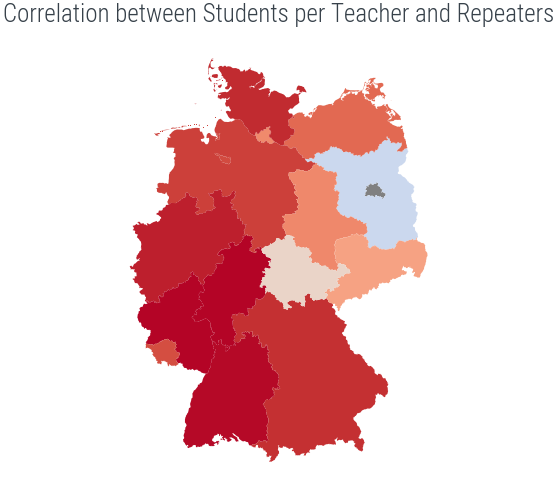

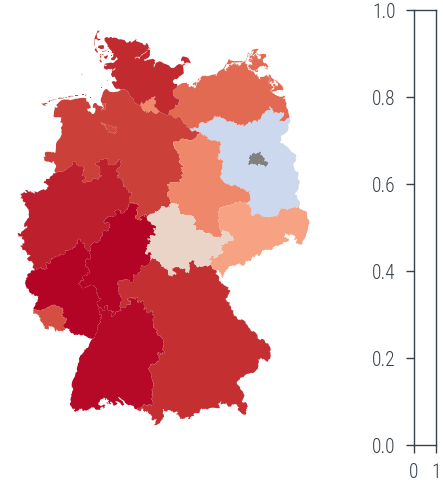

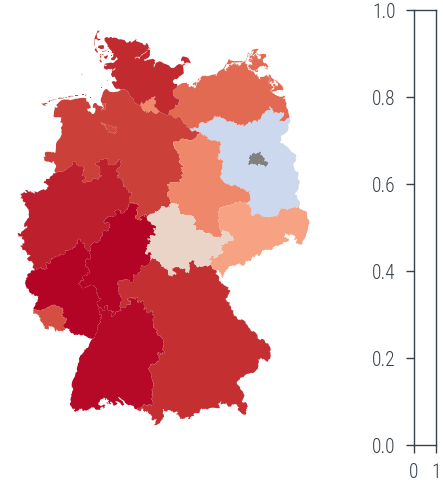

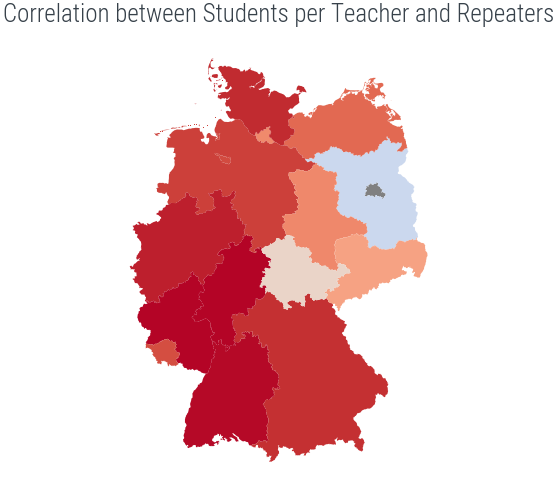

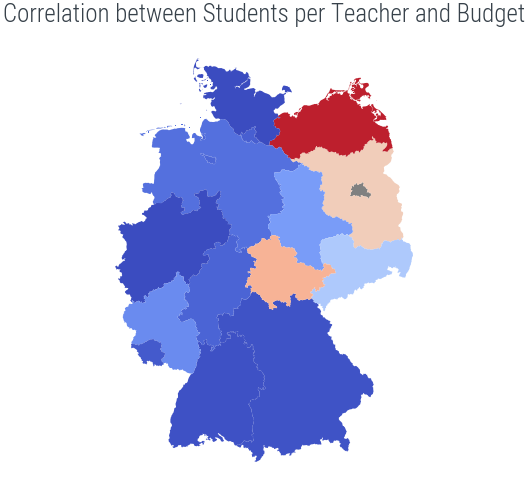

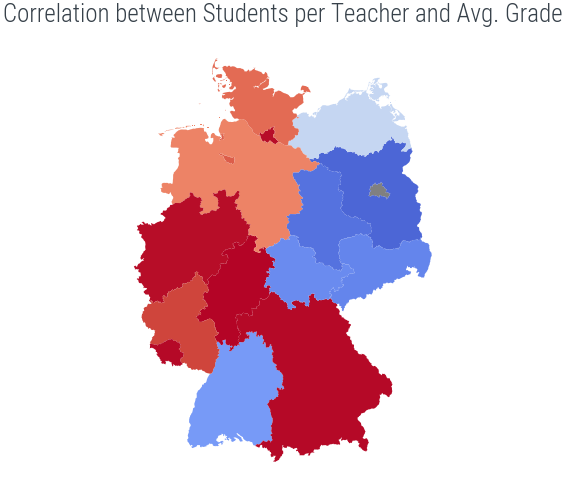

In [58]:

import matplotlib.pyplot as plt
import school_analysis.plotting.germany_heatmap_lib as heatmaplib

plotter = heatmaplib.GermanStatesHeatmapPlot()
heatmap_dictionary = dict(zip(result["state"], result["Repeaters"]))

fig, ax, cbar = plotter.create_plot(
    heatmap_dictionary, default_state_color="gray")
ax.set_title("Correlation between Students per Teacher and Repeaters")
# cbar.set_label("Coefficient of correlation")
plt.show()


plotter = heatmaplib.GermanStatesHeatmapPlot()
heatmap_dictionary = dict(zip(result["state"], result["Budget"]))

fig, ax, cbar = plotter.create_plot(
    heatmap_dictionary, default_state_color="gray")
ax.set_title("Correlation between Students per Teacher and Budget")
# cbar.set_label("Coefficient of correlation")
plt.show()

plotter = heatmaplib.GermanStatesHeatmapPlot()
heatmap_dictionary = dict(zip(result["state"], result["Avg. Grade"]))

fig, ax, cbar = plotter.create_plot(
    heatmap_dictionary, default_state_color="gray")
ax.set_title("Correlation between Students per Teacher and Avg. Grade")
# cbar.set_label("Coefficient of correlation")
plt.show()

## Correlation between the teachers to students ratio and the number of students w\o secondary school degree


In [59]:
wo_degree_c = children_wo_degree.copy()
ts_state_c = teachers_students_state.copy()

ts_state_c = ts_state_c[
    (ts_state_c["Gender_students"] == "all")
    & (ts_state_c["Gender_teachers"] == "all")
    & (ts_state_c["Contract Type"].isin(CONTRACT_TYPE))
]
ts_state_c = ts_state_c.groupby(
    ["Year"])["Students per Teacher"].mean().reset_index()

In [60]:
wo_deg_ts = pd.merge(wo_degree_c, ts_state_c, on=["Year"])
wo_deg_ts = wo_deg_ts[wo_deg_ts["Year"] > 1998]  # Filter out 1998
wo_deg_ts[list(set(wo_deg_ts.columns) - set(["Year"]))].corr()

,Total students,Without degree (rel.),Students per Teacher,Without degree
Total students,1.000000,0.935819,0.801069,0.961930
Without degree (rel.),0.935819,1.000000,0.858653,0.996115
Students per Teacher,0.801069,0.858653,1.000000,0.863432
Without degree,0.961930,0.996115,0.863432,1.000000


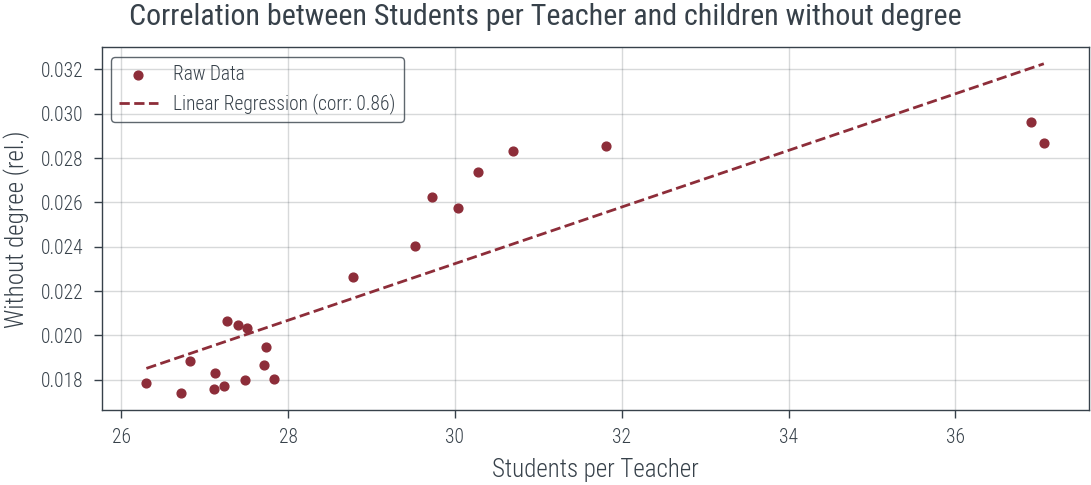

In [64]:
fig, ax = plt.subplots(1, 1)

ax.scatter(
    wo_deg_ts["Students per Teacher"],
    wo_deg_ts["Without degree (rel.)"],
    s=10,
    label="Raw Data"
)

# Linear regression
corr = np.corrcoef(wo_deg_ts["Students per Teacher"],
                   wo_deg_ts["Without degree (rel.)"])[0][1]
X = np.vstack([np.ones(len(wo_deg_ts["Students per Teacher"])),
              wo_deg_ts["Students per Teacher"]]).T
y = wo_deg_ts["Without degree (rel.)"]
w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
minimum = wo_deg_ts["Students per Teacher"].min()
maximum = wo_deg_ts["Students per Teacher"].max()
xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
ax.plot(
    xp,
    w[0] + w[1] * xp,
    "--",
    label="Linear Regression (corr: {:.2f})".format(corr)
)

ax.grid(True)
ax.legend()
ax.set_xlabel("Students per Teacher")
ax.set_ylabel("Without degree (rel.)")
fig.suptitle(
    "Correlation between Students per Teacher and children without degree")
plt.show()

## Correlation Gymnasien - Grades


In [62]:
ts_gym_type_c = ts_type_c[ts_type_c["School Type"].isin(
    ["Gymnasien"])]
ts_gym_grade = pd.merge(ts_gym_type_c, avg_grade, on=[
                        "Year"]).dropna().drop_duplicates()
print("Corr [TS, Grade] by Type: ", np.corrcoef(
    ts_gym_grade["Students per Teacher"], ts_gym_grade["Average Grade"])[0][1])

Corr [TS, Grade] by Type:  0.9756628375840231


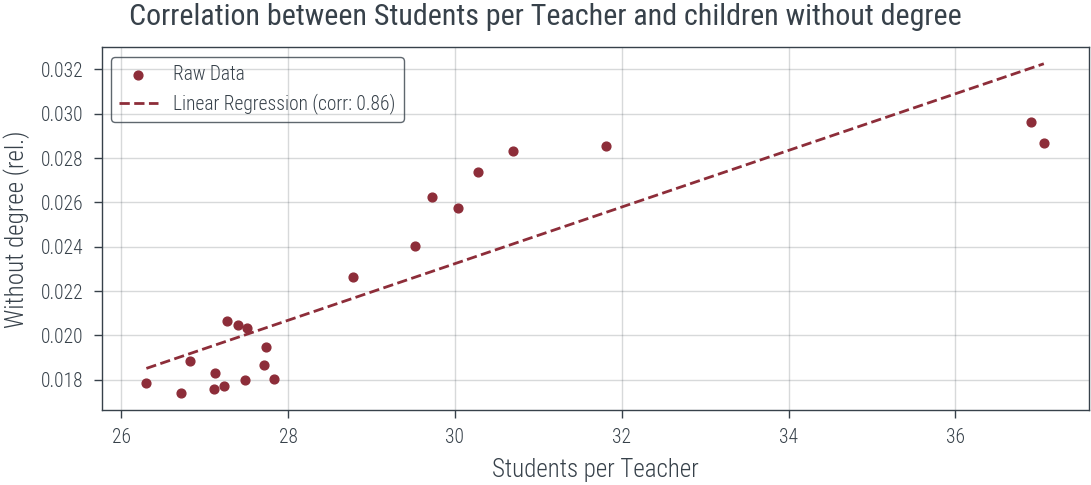

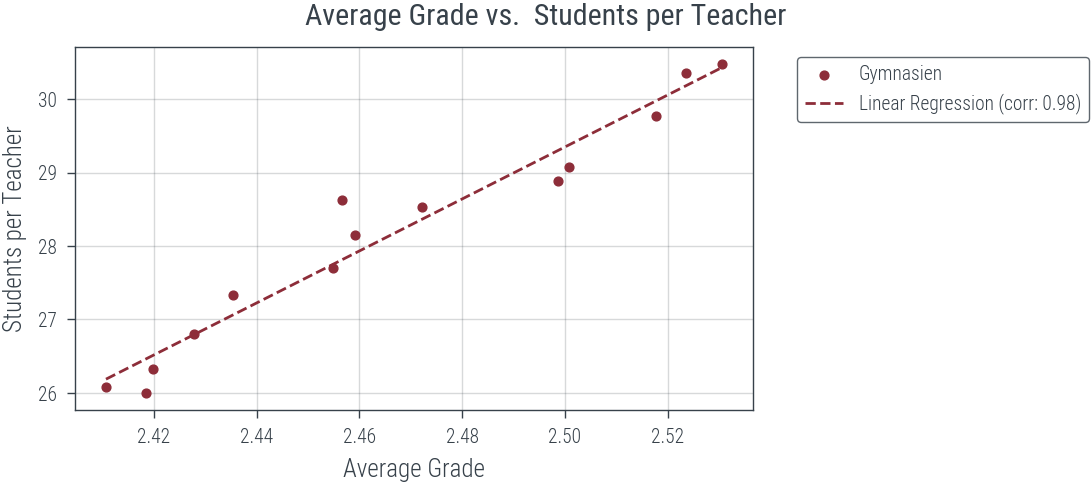

In [63]:
GeneralPlots.school_type_corr_plot(
    ts_gym_grade,
    "Students per Teacher",
    "Average Grade",
    school_types=["Gymnasien"],
    avg=False
)